In [6]:
import networkx as nx
import pandas as pd
import os
import glob
import matplotlib
import scipy
import random
import numpy as np
import matplotlib.pyplot as plt


In [7]:
username_dict = {
    "samuel": "swang330",
    "alex": "alex.kalis",
    "alexandra": "alexandrapurdy_",
    "kabir": "kabir_aho",
    "kirin": "kirindanek",
    "liam": "liam_hochman",
    "noah": "noahpurow",
    "seoeun": "seoeunki.m",
    "will": "will.deley",
    "zach": "zach.annuik",
    "yota": "yota.katsikouli",
    "dis_abroad": "dis.copenhagen",
     "ely": "elybrayboy"
}

In [8]:
os.chdir(os.path.expanduser("~/Desktop"))
print("✔️  cwd is now:", os.getcwd())  

current_dir    = os.getcwd()
csv_directory  = os.path.join(current_dir, "csv_files")
print("Looking for CSVs in:", csv_directory)
print("Found:", glob.glob(os.path.join(csv_directory, "*_data.csv")))
# ---

def build_network_from_csvs(csv_dir):
    G = nx.DiGraph()
    csv_files = glob.glob(os.path.join(csv_dir, "*_data.csv"))

    if not csv_files:
        print(f"error: no '*_data.csv' files found in directory: {csv_dir}")
        return None

    print(f"found {len(csv_files)} CSV files to process.")

    for csv_path in csv_files:
        filename = os.path.basename(csv_path)
        print(f"processing: {filename}...")

        parts = filename.replace("_data.csv", "").split('_')
        if len(parts) < 2:
            print(f"warning: skipping file with unexpected name format: {filename}")
            continue

        relationship_type = parts[-1]
        central_node = username_dict["_".join(parts[:-1])]
        print(central_node)

        if relationship_type not in ["followers", "following"]:
            print(f"warning: Skipping file - cannot determine relationship type (expected 'followers' or 'following'): {filename}")
            continue

        if not central_node:
             print(f"warning: Skipping file - could not determine central node: {filename}")
             continue
             
        G.add_node(central_node)

        try:
            df = pd.read_csv(csv_path)
            if "username" not in df.columns:
                print(f"warning: Skipping file - 'username' column not found in {filename}")
                continue

            other_users = df["username"].dropna().unique()

            for user in other_users:
                G.add_node(user) # Add other user node if it doesn't exist

                if relationship_type == "followers":
                    # Edge from follower (user) to central_node
                    G.add_edge(user, central_node)
                elif relationship_type == "following":
                    # Edge from central_node to the person they follow (user)
                    G.add_edge(central_node, user)

            print(f"-> added {len(other_users)} edges for {central_node} ({relationship_type}).")

        except pd.errors.EmptyDataError:
             print(f"warning: Skipping empty file: {filename}")
        except Exception as e:
            print(f"error processing file {filename}: {e}")

    return G

network_graph = build_network_from_csvs(csv_directory)


print("\n--- Graph Construction Complete ---")
print(f"Number of nodes (users): {network_graph.number_of_nodes()}")
print(f"Number of edges (relationships): {network_graph.number_of_edges()}")


✔️  cwd is now: /Users/kabirhinduja-obregon/Desktop
Looking for CSVs in: /Users/kabirhinduja-obregon/Desktop/csv_files
Found: ['/Users/kabirhinduja-obregon/Desktop/csv_files/dis_abroad_followers_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/samuel_following_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/alex_following_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/zach_followers_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/liam_followers_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/dis_abroad_following_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/samuel_followers_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/liam_following_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/alex_followers_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/zach_following_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/kirin_following_data.csv', '/Users/kabirhinduja-obregon/Desktop/csv_files/yota_f

found 26 CSV files to process.
processing: dis_abroad_followers_data.csv...
dis.copenhagen
-> added 4856 edges for dis.copenhagen (followers).
processing: samuel_following_data.csv...
swang330
-> added 1104 edges for swang330 (following).
processing: alex_following_data.csv...
alex.kalis
-> added 1675 edges for alex.kalis (following).
processing: zach_followers_data.csv...
zach.annuik
-> added 603 edges for zach.annuik (followers).
processing: liam_followers_data.csv...
liam_hochman
-> added 817 edges for liam_hochman (followers).
processing: dis_abroad_following_data.csv...
dis.copenhagen
-> added 240 edges for dis.copenhagen (following).
processing: samuel_followers_data.csv...
swang330
-> added 683 edges for swang330 (followers).
processing: liam_following_data.csv...
liam_hochman
-> added 1678 edges for liam_hochman (following).
processing: alex_followers_data.csv...
alex.kalis
-> added 1235 edges for alex.kalis (followers).
processing: zach_following_data.csv...
zach.annuik
-> add

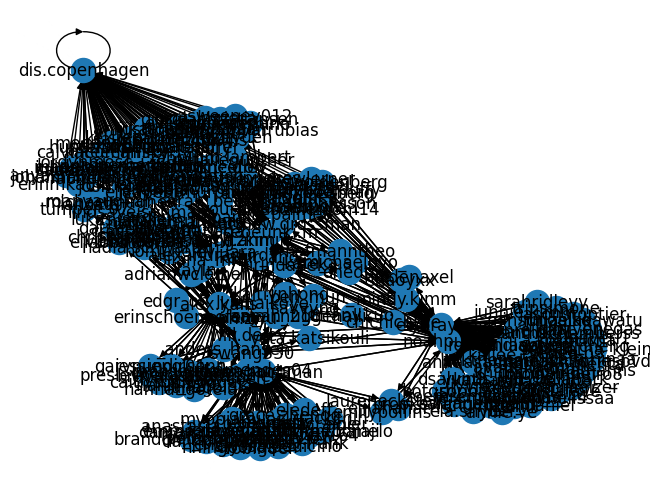

In [9]:
# Creaitng a subgraph of the initial network which containts only nodes with an out-degree of at least 2 (where they follow at least 2 DIS students/accounts from our class)
Initial_G = build_network_from_csvs(csv_directory)
print("\n--- Graph Construction Complete ---")
print(f"Number of nodes (users) inital: {Initial_G.number_of_nodes()}")

Tight_G = Initial_G.subgraph([node for node, degree in Initial_G.out_degree() if degree >= 2]) # Creating subgraoh where out degree is at least 2
print(f"Number of nodes (users) tight: {Tight_G.number_of_nodes()}")

# Visualizing the graph with labels
pos = nx.spring_layout(Tight_G)
nx.draw(Tight_G, pos, with_labels=True)
plt.show()


In [10]:
# SI Model here where nodes which share positive impressions
# We use the SI model to update the network to simulate the probablistic impact of sharing to ones followers and how it may spread.
# Returns a graoh updated with the new impressions to our information cascade function
def SI(G, p_inf, p_inf_sponsor):
        
    for n in G.nodes():

        if G.nodes[n]["impression"] == 'sponsor': # influence probability is higher due to sponsored influencers frequency of posting
            neighb_list = [neighbor for neighbor in G.predecessors(n)] # Neighbour list of only those who follow node n (where the edge is directed from the neighbour towards n)

            # if all my neighbors are all sharing already, nothing happens
            # else, I influence each of my non sharing neighbours at the given probabiilty
            sup_neighb = [n for n in neighb_list if G.nodes[n]["impression"] == 'positive no share' or G.nodes[n]["impression"] == 'none']
            N_sup_neighb = len(sup_neighb)
            
            if N_sup_neighb != 0:

                for f in sup_neighb:
                    # probability generator
                    p = np.random.rand()
                    if p < p_inf_sponsor:
                        G.nodes[f]["impression"] = 'positive share'
                        print(f"Node {f} influenced by {n} (sponsor) to become positive share.")

        if G.nodes[n]["impression"] == 'positive share': # influence probility is lower due to the fact that they are not influencers and post less
            neighb_list = [neighbor for neighbor in G.predecessors(n)] # Neighbour list of only those who follow node n (where the edge is directed from the neighbour towards n)

            # if all my neighbors are all sharing already, nothing happens
            # else, I influence each of my non sharing neighbours at the given probabiilty
            sup_neighb = [n for n in neighb_list if G.nodes[n]["impression"] == 'positive no share' or G.nodes[n]["impression"] == 'none']
            N_sup_neighb = len(sup_neighb)
            
            if N_sup_neighb != 0:

                for f in sup_neighb:
                    # probability generator
                    p = np.random.rand()
                    if p < p_inf:
                        G.nodes[f]["impression"] = 'positive share'
                        print(f"Node {f} influenced by {n} (sponsor) to become positive share.")
    return G

In [11]:
# Initializing our complex network with respect to each individual nodes impression and color. The graph shall be initialized with the chosen sponsor(s) and the rest of the nodes with no impression.
# Colors for each impression are also assigned


def initialize_graph(G, influencer_list):
    
    impression = ['sponsor', 'positive share', 'positive no share' 'none']
    node_colours =[]
    

    for node in G.nodes(): # Assigning impressions
        if node in influencer_list:
            start_impression = 'sponsor'
        else:
            start_impression = 'none'
        
        G.nodes[node]['impression'] = start_impression #Assigning color
        if start_impression == 'positive share':
            node_colours.append('darkgreen')
        elif start_impression == 'positive no share':
            node_colours.append('lightgreen')
        elif start_impression == 'sponsor':
            node_colours.append('blue')
        else:
            node_colours.append('red')

    print("Initializing the graph with the following sponsered influencers: ")
    for influencer in influencer_list:
        print(influencer)
    print('The initialized graph has {} nodes as sponsered influencers and {} nodes with no impression.'.format(node_colours.count('blue'), node_colours.count('red')))

    return G, node_colours



In [12]:
# Using Initialization function as drawing initial graph
#G_use, node_colours = initialize_graph(Tight_G)
#nx.draw(G_use, node_color = node_colours, with_labels = True)

In [13]:
# Running 365 iterations to simulate the Information Cascade x SI models evolution with influencers and each nodes impressions.
def one_year_simulation(G, influencer_list, product_threshold):
    iteration = 0
    W = G.copy()
    while iteration < 365:
        print('Iteration No.: ', (iteration+1))
        iteration += 1
        W, colours = update_rule(W, product_threshold)

    print("Sharing the one year conclusion of the graph with the following sponsered influencers: ")
    for influencer in influencer_list:
        print(influencer)
    print('The final graph has had {} sponsered influencer(s), {} nodes with a positive impression, {} of which were sharing, and {} of which did not. There were {} still without any impression'.format(colours.count('blue'), (colours.count('darkgreen') + colours.count('lightgreen')), colours.count('darkgreen'), colours.count('lightgreen'), colours.count('red')))
    plt.figure()  
    plt.title(" {} Influencer Network with {} positive impression, {} positive share, {} positive no share, {} no impression, for a product threshold of {}".format(influencer_list, (colours.count('darkgreen') + colours.count('lightgreen')), colours.count('darkgreen'), colours.count('lightgreen'), colours.count('red'), product_threshold))
    nx.draw(W, node_color = colours)

    # Counting the number of nodes with different impressions
    count_sponsored_influencers = colours.count('blue')
    count_positive_impression = colours.count('darkgreen') + colours.count('lightgreen')
    count_positive_shared = colours.count('darkgreen')
    count_positive_no_share = colours.count('lightgreen')
    count_no_impression = colours.count('red')

    return count_sponsored_influencers, count_positive_impression, count_positive_shared, count_positive_no_share, count_no_impression

In [14]:
# Let us here implement the adoption strategy for our information cascade model which simulates the more consistent or long term impression result of accounts followed sharing
# We also use the SI model to update the network to simulate the probablistic impact of sharing and how it may spread.
# Our update rule is: if a node has more than the product threshold % of their following as having shared , then it will also get a positive impression
# In this one year simulation there is no case where a node will change from positive share to positive no share or none, or from poisitive no share to none, so no inverse update rule is needed.
# At the same time, we will be keeping track of the correct colours for each node
 
def update_rule(G, product_threshold):

    # Run G through the SI model update returning as G_after_SI to simulate the impacts of sharing
    G_after_SI = SI(G, 0.000029, 0.0006) #probability of influence for positive sharers and influencers respectively

    new_graph = G_after_SI.copy() #create a copy of original to store next iteration of graph

    colours = []
    
    for node in G_after_SI.nodes():
        cur_impression = G_after_SI.nodes[node]['impression']
        #print("Node "+str(node)+" has impression: "+str(cur_impression))
        node_neighbors = list(G_after_SI.successors(node)) # Neighber list of only those who are followed by the node. (where the edge is directed from the node towards its follower node)
        #print("Node "+str(node)+" has neighbors: "+str(node_neighbors))
        neighbors_impressions = [G_after_SI.nodes[i]['impression'] for i in node_neighbors]

        count_positive_no_share = neighbors_impressions.count('positive no share')
        count_positive_share = neighbors_impressions.count('positive share')
        count_none = neighbors_impressions.count('none')
        count_sponsor = neighbors_impressions.count('sponsor')


        # Using different impression thresholds based on how expensive a product would be bought
        if (count_positive_share + count_sponsor)/ (count_positive_share + count_positive_no_share + count_none + count_sponsor) >= product_threshold and G_after_SI.nodes[node]['impression'] == 'none': 
            new_graph.nodes[node]['impression'] = 'positive no share'
            colours.append('lightgreen')
            print("Node "+str(node)+" has changed impression to positive no share")
            
        else:
            new_graph.nodes[node]['impression'] = cur_impression
            if cur_impression == 'positive share':
                colours.append('darkgreen')
            elif cur_impression == 'positive no share':
                colours.append('lightgreen')
            elif cur_impression == 'sponsor':
                colours.append('blue')
            else:
                colours.append('red')

    return new_graph, colours

In [15]:
# Function which runs the simulation for each influencer in the influencer list with a specifc product threshold and returns a table with the results. Draws a graph ordered by most positive impressions

def run_year_long_simulation(G, influencer_list, product_threshold):
    results = []
    for influencer in influencer_list:
        print("Running simulation for influencer: ", influencer)
        G_use, node_colours = initialize_graph(Tight_G, [influencer])
        count_sponsored_influencers, count_positive_impression, count_positive_shared, count_positive_no_share, count_no_impression = one_year_simulation(G_use, [influencer], product_threshold)
        results.append({
            'Influencer': influencer,
            'Sponsored Influencers': count_sponsored_influencers,
            'Positive Impressions': count_positive_impression,
            'Positive Shared': count_positive_shared,
            'Positive No Share': count_positive_no_share,
            'No Impression': count_no_impression
        })
    
    df = pd.DataFrame(results)
    result_table = df
    result_table = result_table.sort_values('Positive Impressions', ascending=False)
    result_table = result_table[result_table['No Impression'] != 0]  # Remove rows with no impression
    result_table.plot(x='Influencer', y=['Sponsored Influencers', 'Positive Impressions', 'Positive Shared', 'Positive No Share'], kind='bar', color=['blue', 'gold', 'darkgreen', 'lightgreen'])
    plt.xlabel('Influencer')
    plt.ylabel('Count')
    plt.title('Simulation Results with product threshold {}'.format(product_threshold))
    plt.show()

    return result_table



Running simulation for influencer:  swang330
Initializing the graph with the following sponsered influencers: 
swang330
The initialized graph has 1 nodes as sponsered influencers and 235 nodes with no impression.
Iteration No.:  1
Node kaiiiii__5 has changed impression to positive no share
Node kenneth.feliz has changed impression to positive no share
Node o_ovaltine267 has changed impression to positive no share
Node robin8er has changed impression to positive no share
Node victoriaveak has changed impression to positive no share
Node _sararhe_ has changed impression to positive no share
Node anastasia.karavasili has changed impression to positive no share
Node cross.joeyy has changed impression to positive no share
Node chloesross has changed impression to positive no share
Node yota.katsikouli has changed impression to positive no share
Node sabrinaw.64 has changed impression to positive no share
Node savvyng has changed impression to positive no share
Node zabei.frank has changed i

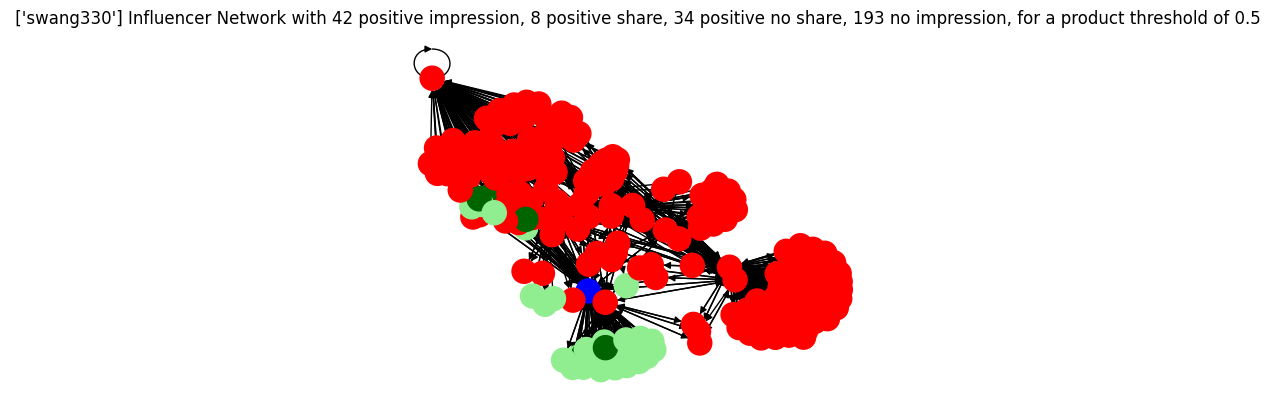

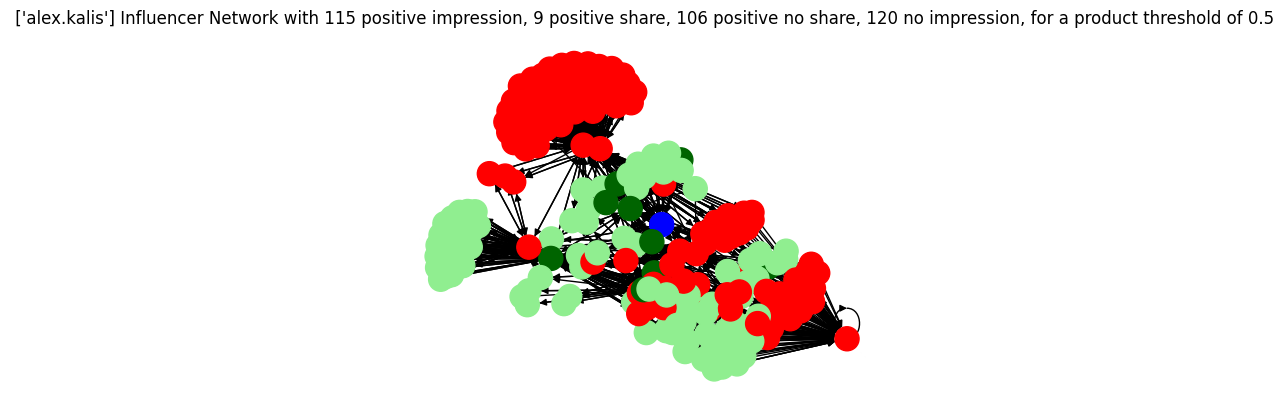

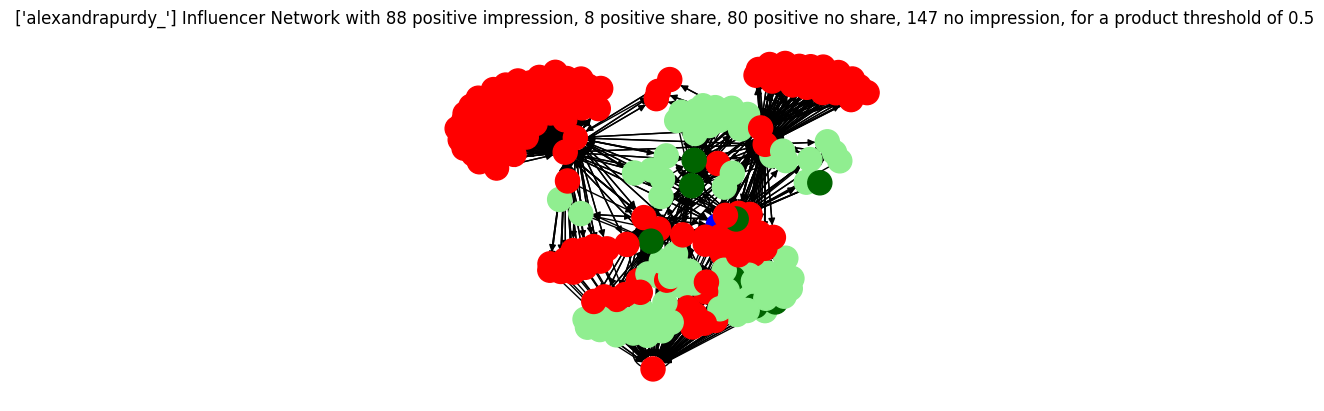

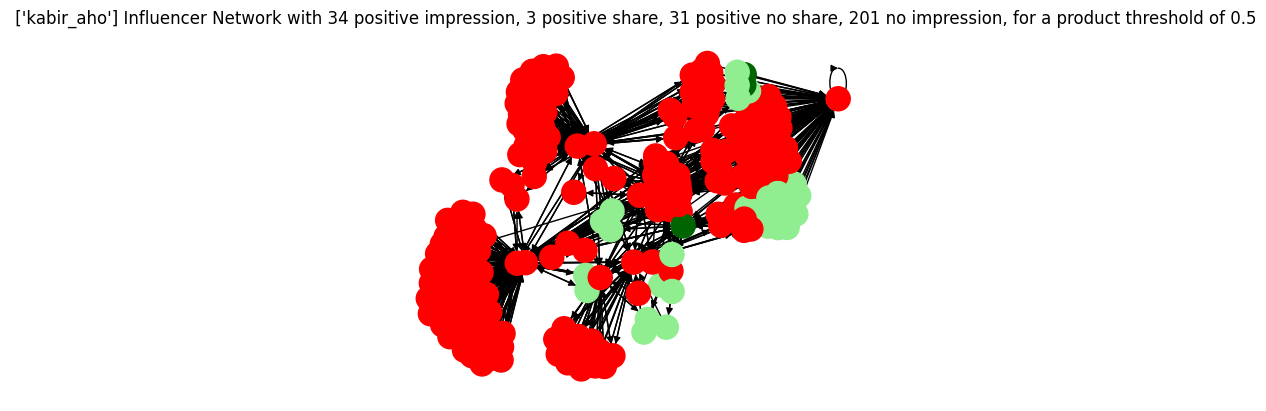

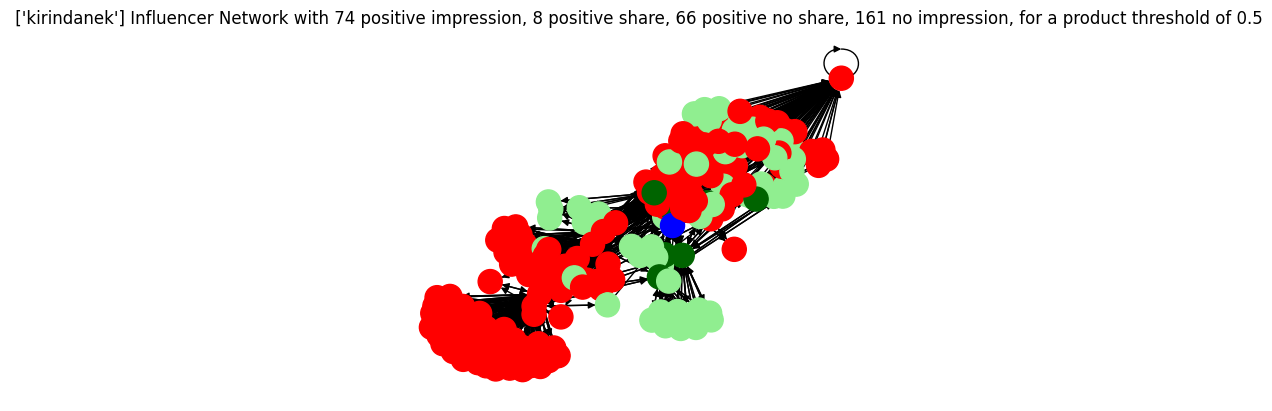

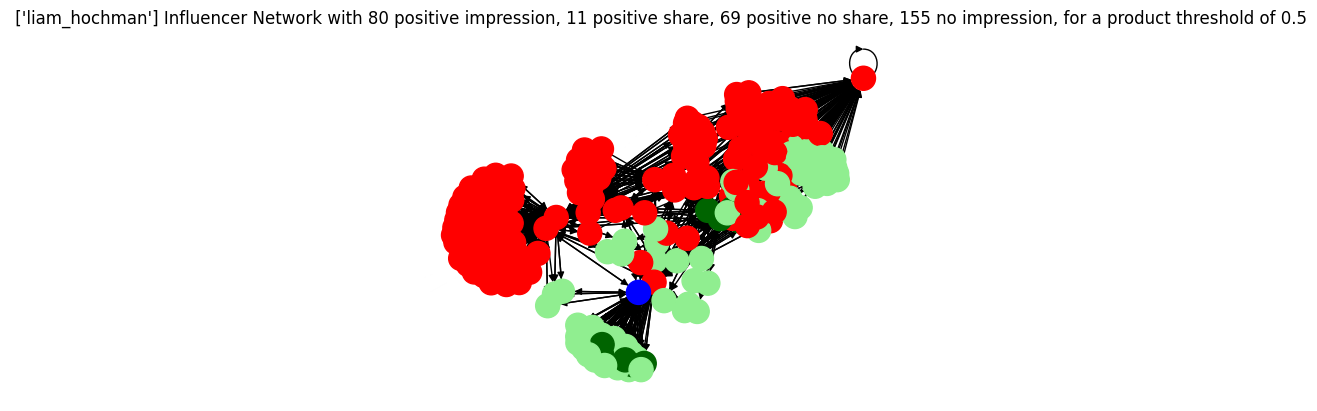

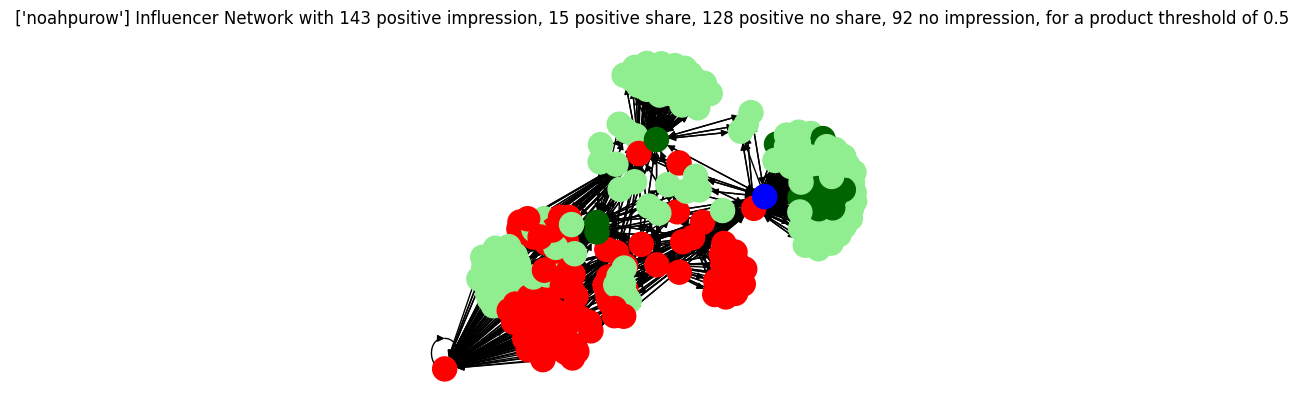

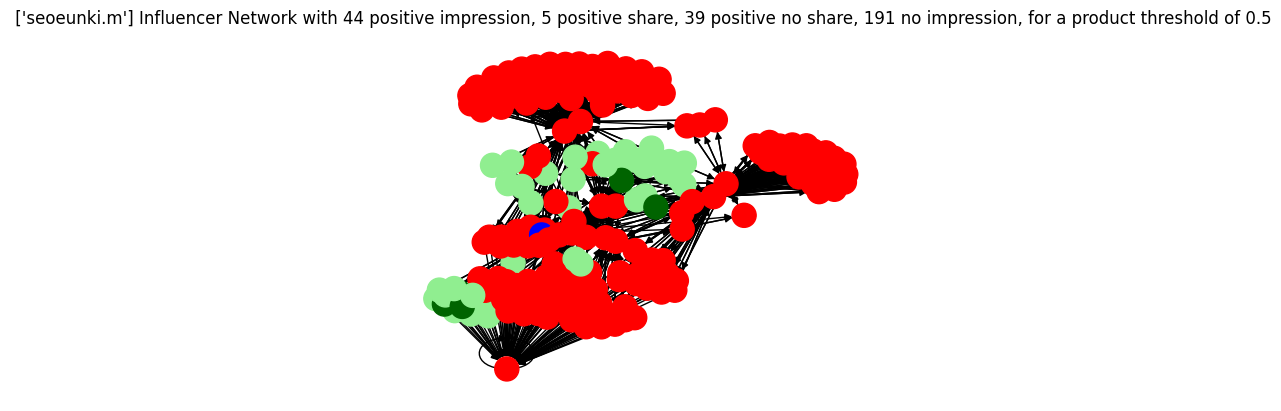

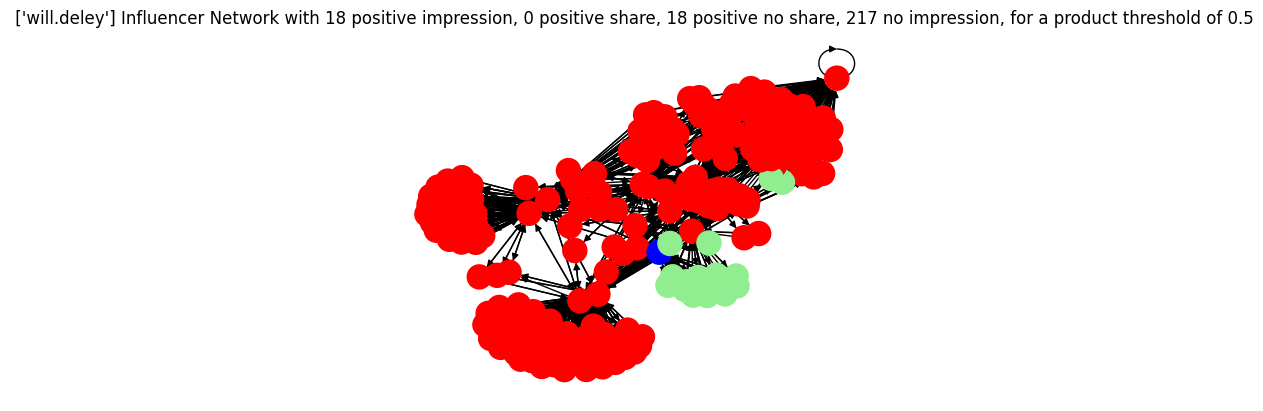

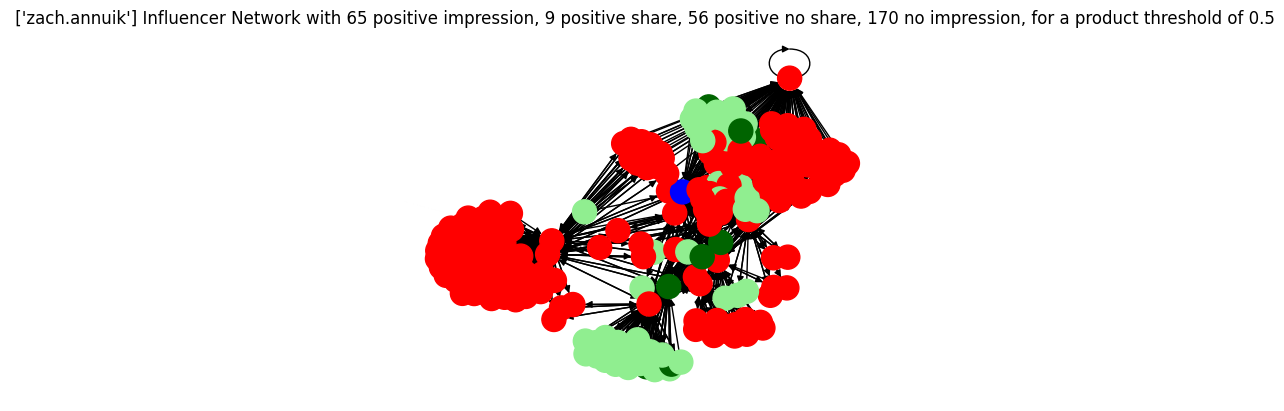

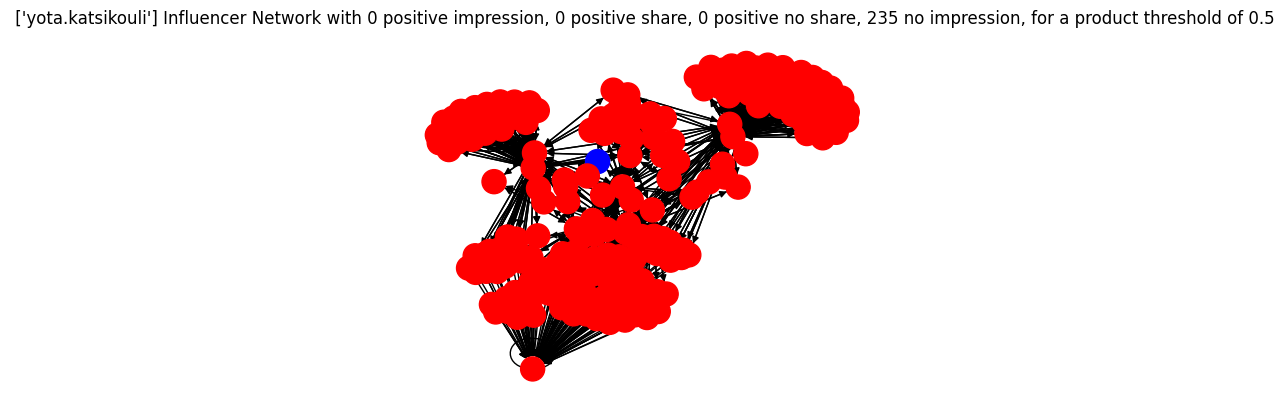

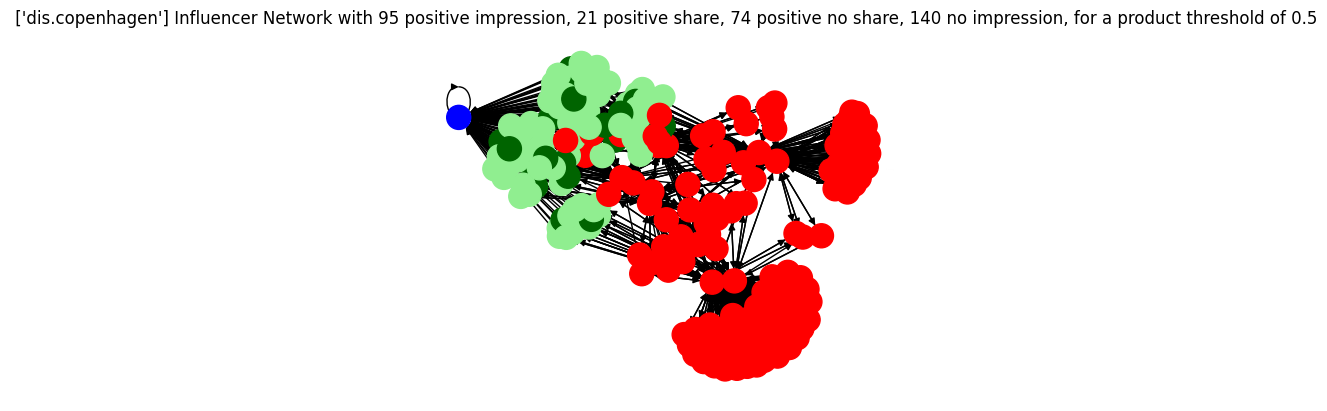

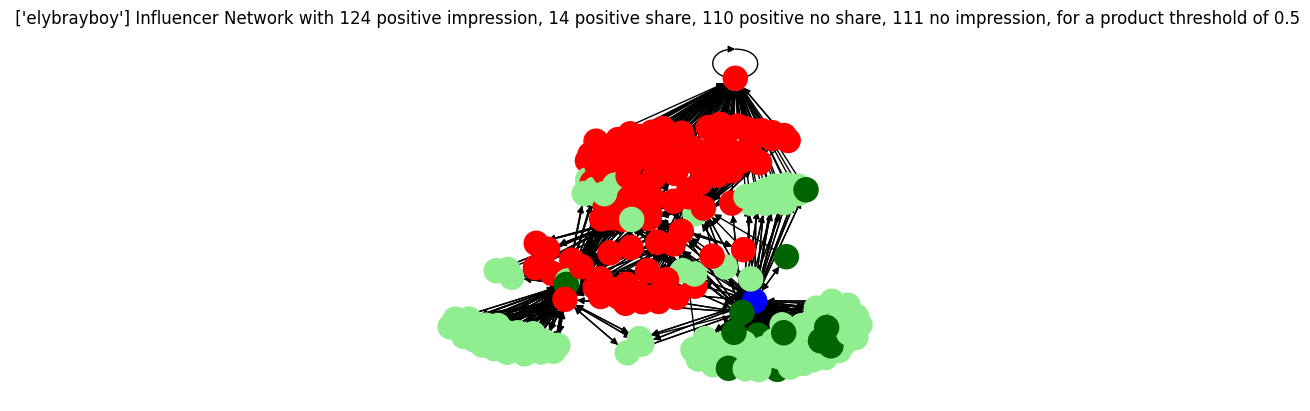

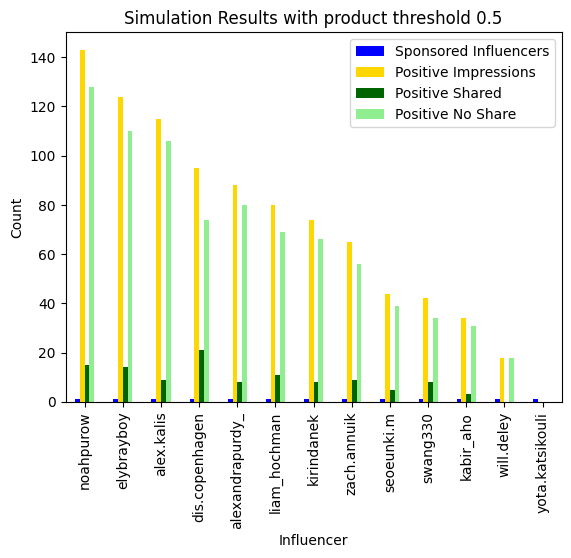

In [30]:
# Running the simulation for each influencer

influencer_list = list(username_dict.values())
result_table = run_year_long_simulation(Tight_G, influencer_list, 0.5)